In [31]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer                       
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [32]:
# get articles into articles, labels into labels

articles = []
labels = []

with open('input/bbc_text_cls.csv') as f:
    running_art = ''
    for l in f.readlines()[1:]:
        if '",' not in l or '", ' in l:
            running_art += f'{l.strip()} '
        else:
            last_line = l.split('",')
            assert len(last_line) == 2
            articles.append(running_art + last_line[0].strip())
            labels.append(last_line[1].strip())
            running_art = ''


In [33]:
# get labels into category values
label2int = {}
count = 0
for l in labels:
    if l not in label2int:
        label2int[l] = count
        count += 1

int_labels = [label2int[l] for l in labels]
df = pd.DataFrame(list(zip(articles, int_labels)), columns=['text', 'label'])

df.head()

,text,label
0,"""Ad sales boost Time Warner profit Quarterly ...",0
1,"""Dollar gains on Greenspan speech The dollar ...",0
2,"""Yukos unit buyer faces loan claim The owners...",0
3,"""High fuel prices hit BA's profits British Ai...",0
4,"""Pernod takeover talk lifts Domecq Shares in ...",0


In [34]:
df_train, df_test = train_test_split(df, test_size=0.3)

tfidf = TfidfVectorizer()
Xtrain = tfidf.fit_transform(df_train['text'])
Xtest = tfidf.transform(df_test['text'])

Ytrain = df_train['label']
Ytest = df_test['label']

In [35]:
# num classes (K), counting from 1, eqaul to len of label2int
K = len(label2int)

# input feature len (D) equal to length of tfidf vector
D = Xtrain.shape[1]

K, D

(5, 25562)

In [36]:
# D = num features
# M = output nums, hyperparameter (arbitraty)
# K = num classes. softmax like argmax, but returns probs for all classes (good for training)

M = 300

i = Input(shape=(D,))
x = Dense(M, activation='relu')(i)
# x = Dense(M, activation='relu')(x)
# x = Dense(M, activation='relu')(x)
x = Dense(K)(x)

# use this following final layer only if not using from_logits below
# x = Dense(K, activation='softmax')(x)

model = Model(i, x)

In [37]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 25562)]           0         
                                                                 
 dense_8 (Dense)             (None, 300)               7668900   
                                                                 
 dense_9 (Dense)             (None, 5)                 1505      
                                                                 
Total params: 7,670,405
Trainable params: 7,670,405
Non-trainable params: 0
_________________________________________________________________


In [38]:

# SparseCategoricalCrossentropy returns actual values. more efficient, less intuitive
# CategoricalCrossentropy would also work but returns a vector of probs for each input. aka "one-hot encoding"
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

Xtrain = Xtrain.toarray()
Xtest = Xtest.toarray()

In [39]:
r = model.fit(
    Xtrain, Ytrain,
    validation_data=(Xtest, Ytest),
    epochs=10,
    batch_size=128
)

Epoch 1/10
12/12 [==============================] - 3s 201ms/step - loss: 1.4624 - accuracy: 0.7656 - val_loss: 1.1992 - val_accuracy: 0.9799
Epoch 2/10
12/12 [==============================] - 2s 139ms/step - loss: 0.9310 - accuracy: 0.9947 - val_loss: 0.7304 - val_accuracy: 0.9783
Epoch 3/10
12/12 [==============================] - 1s 120ms/step - loss: 0.4716 - accuracy: 0.9980 - val_loss: 0.4077 - val_accuracy: 0.9845
Epoch 4/10
12/12 [==============================] - 2s 150ms/step - loss: 0.2150 - accuracy: 0.9987 - val_loss: 0.2476 - val_accuracy: 0.9845
Epoch 5/10
12/12 [==============================] - 2s 138ms/step - loss: 0.1048 - accuracy: 0.9993 - val_loss: 0.1771 - val_accuracy: 0.9845
Epoch 6/10
12/12 [==============================] - 2s 130ms/step - loss: 0.0593 - accuracy: 1.0000 - val_loss: 0.1425 - val_accuracy: 0.9845
Epoch 7/10
12/12 [==============================] - 1s 114ms/step - loss: 0.0384 - accuracy: 1.0000 - val_loss: 0.1242 - val_accuracy: 0.9845
Epoch 

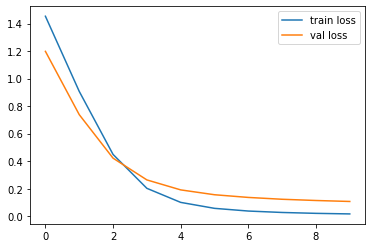

In [29]:
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()

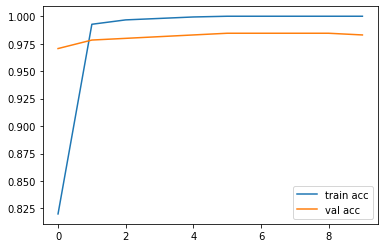

In [30]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()